## Models in Computational Neuroscience.

There are different levels of modelling first suggested by David Marr.
1) Computational level. (What is the goal of a computation? What is the strategy?)
2) Representational level. (How can a theory be implemented? What is the algorythm?)
3) Hardware implementation. (How can it be realized on a physical substrate?)

To represent a process there is a need to choose a suitable computational model.

# Hodgkin-Huxley model.

A good primer on a Hodgkin-Huxley model could be found here:
https://neuronaldynamics.epfl.ch/online/Ch2.S2.html

Let's try to implement this model on a piece of basal ganglia system.

In [19]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import scipy.signal
import time

In [20]:
def findfreq(sig): #in Hz
    #delta = 1e-5 #remember that only with dt 0.01 and t 1000 ms
    val = sig
    h=scipy.signal.detrend(val)
    peaks=scipy.signal.find_peaks(h,height=23)[0]
    #fr=1/(np.mean(np.diff(peaks))*delta)
    fr=np.size(peaks)
    if np.size(peaks)<1:
        fr=0
           
    return fr

In [21]:
def plotres(vsn, vge, vgi, t,tmax, dt):

    ##calculate freqeuncy for plotting
    fr1=findfreq(vsn[0,:])
    fr2=findfreq(vge[0,:])
    fr3=findfreq(vgi[0,:])  
    
    ##Plots membrane potential for one cell in each nucleus  
    plt.figure() 
    
    plt.subplot(1,3,1) #for 1st STN neuron
    plt.plot(t,vsn[0,:])
    plt.xlim(0, tmax)
    plt.ylim(-100, 80) 
    plt.title('STN, FR: %s Hz' %(int(round(fr1))))
    plt.ylabel('Vm (mV)') 
    plt.xlabel('Time (msec)')
    
    plt.subplot(1,3,2) #for 1st GPe neuron
    plt.plot(t,vge[0,:])
    plt.xlim(0, tmax)
    plt.ylim(-100, 80) 
    plt.title('GPe, FR: %s Hz' %(int(round(fr2))))
    plt.ylabel('Vm (mV)') 
    plt.xlabel('Time (msec)')
    
    plt.subplot(1,3,3) #for 1st GPi neuron
    plt.plot(t,vgi[0,:])
    plt.xlim(0, tmax)
    plt.ylim(-100, 80) 
    plt.title('GPi, FR: %s Hz' %(int(round(fr3))))
    plt.ylabel('Vm (mV)')
    plt.xlabel('Time (msec)')
    
    plt.show()
    

In [22]:
#Gating parameters
@jit(nopython=True, cache=True)
def Hinf(V):
    return 1/(1+np.exp(-(V+57)/2))

#GPe, GPi
    
@jit(nopython=True, cache=True)
def gpe_ainf(V):
    return 1/(1+np.exp(-(V+57)/2))

@jit(nopython=True, cache=True)
def gpe_hinf(V):
    return 1/(1+np.exp((V+58)/12))

@jit(nopython=True, cache=True)
def gpe_minf(V):
    return 1/(1+np.exp(-(V+37)/10))

@jit(nopython=True, cache=True)
def gpe_ninf(V):
    return 1/(1+np.exp(-(V+50)/14))

@jit(nopython=True, cache=True)
def gpe_rinf(V):
    return 1/(1+np.exp((V+70)/2))

@jit(nopython=True, cache=True)
def gpe_sinf(V):
    return 1/(1+np.exp(-(V+35)/2))

@jit(nopython=True, cache=True)
def gpe_tauh(V):
    return 0.05+0.27/(1+np.exp(-(V+40)/-12))

@jit(nopython=True, cache=True)
def gpe_taun(V):
    return 0.05+0.27/(1+np.exp(-(V+40)/-12))
#STN gating parameters
@jit(nopython=True, cache=True)
def stn_taur(V):
    return 7.1+17.5/(1+np.exp(-(V-68)/-2.2))

@jit(nopython=True, cache=True)
def stn_taun(V):
    return 1+100/(1+np.exp(-(V+80)/-26))

@jit(nopython=True, cache=True)
def stn_tauh(V):
    return 1+500/(1+np.exp(-(V+57)/-3))

@jit(nopython=True, cache=True)
def stn_tauc(V):
    return 1+10/(1+np.exp((V+80)/26))

@jit(nopython=True, cache=True)
def stn_rinf(V):
    return 1/(1+np.exp((V+67)/2))

@jit(nopython=True, cache=True)
def stn_ninf(V):
    return 1/(1+np.exp(-(V+32)/8.0))

@jit(nopython=True, cache=True)
def stn_minf(V):
    return 1/(1+np.exp(-(V+30)/15))

@jit(nopython=True, cache=True)
def stn_hinf(V):
    return 1/(1+np.exp((V+39)/3.1))

@jit(nopython=True, cache=True)
def stn_cinf(V):
    return 1/(1+np.exp(-(V+20)/8))

@jit(nopython=True, cache=True)
def stn_binf(R):
    return 1/(1+np.exp(-(R-0.4)/0.1))-1/(1+np.exp(0.4/0.1))

@jit(nopython=True, cache=True)
def stn_ainf(V):
    return 1/(1+np.exp(-(V+63)/7.8))

In [23]:
def network(tmax,dt,v2,v3,v4,n):
    #membrane parameters
    Cm=1 
    #In order of Th,STN,GP or Th,STN,GPe,GPi
    gl=np.array([0.05, 2.25, 0.1]); El=np.array([-70, -60, -65, -67, -70, -17])
    gna=np.array([3, 37, 120, 30, 100, 120]); Ena=np.array([50, 55, 55, 45, 50, 45]) 
    gk=np.array([5, 45, 30, 3.2, 80, 10, 20]); Ek=np.array([-75, -80, -80, -95, -100, -95, -72])
    gt=np.array([5, 0.5, 0.5]); Et=0
    gca=np.array([0, 2, 0.15]); Eca=np.array([0, 140, 120])
    gahp=np.array([0, 20, 10]) #eahp and ek are the same excluding th

    k1=np.array([0, 15, 10])    #dissociation const of ahp current 
    kca=np.array([0, 22.5, 15]) #calcium pump rate constant

    #synapse params alike in rubin 
    A=np.array([0, 3, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3]) 
    B=np.array([0, 0.1, 0.04, 0.08, 0.1, 0.08, 0.08, 0.1, 0.1, 0.1, 0.08, 0.1])
    the=np.array([0, 30, 20, 20, 30, 20, 20, 30, 30, 30, 20, 30])
    
    ##Synapse parameters
    #In order of Igesn,Isnge,Igege,Isngi,Igegi,Igith 
    gsyn = np.array([1, 0.3, 1, 0.3, 1, .08])   #alike in Rubin gsyn and in So Esyn
    Esyn = np.array([-85, 0, -85, 0, -85, -85]) #alike in Rubin gsyn and in So Esyn

    tau=5; gpeak1=0.3 #parameters for second-order alpha synapse

    #time step
    t=np.arange(0,tmax,dt)

    ##Setting initial matrices
    vsn=np.zeros(shape=(n,len(t)))   #STN membrane voltage
    vge=np.zeros(shape=(n,len(t)))   #GPe membrane voltage
    vgi=np.zeros(shape=(n,len(t)))   #GPi membrane voltage

    Z4=np.zeros(n)  #for 2 order alpha-synapse gpi-th current
    S4=np.zeros(n)  #for alpha-synapse gpi-th current
    S3=np.zeros(n)  #for alpha-synapse ge-ge/sn/str/snr/snc current
    S3_1=np.zeros(n) #for dummy gesn current
    S2=np.zeros(n)  #for alpha-synapse snge/gi/snr current
    Z2=np.zeros(n)  #for 2 order alpha-synapse sn current
    S2_1=np.zeros(n) #for dummy snge current
    S3_2=np.zeros(n) #for dummy gege current

    #initial conditions
    vsn[:,0]=v2
    vge[:,0]=v3
    vgi[:,0]=v4

    #helper variables for gating and synapse params - starting parameters
    R2=stn_rinf(vsn[:,0])        #r for stn
    N2=stn_ninf(vsn[:,0])        #n for stn
    H2=stn_hinf(vsn[:,0])        #h for stn
    C2=stn_cinf(vsn[:,0])        #c for stn
    CA2=np.array([0.1])          #intracellular concentration of Ca2+ in muM for stn
    CA3=CA2                      #for gpe
    CA4=CA2                      #for gpi
    N3=gpe_ninf(vge[:,0])        #n for gpe
    H3=gpe_hinf(vge[:,0])        #h for gpe
    R3=gpe_rinf(vge[:,0])        #r for gpe
    N4=gpe_ninf(vgi[:,0])        #n for gpi
    H4=gpe_hinf(vgi[:,0])        #h for gpi
    R4=gpe_rinf(vgi[:,0])        #r for gpi

    ##Time loop
    for i in range(1, len(t)):
        #previous values
        V2=vsn[:,i-1];     V3=vge[:,i-1];    V4=vgi[:,i-1];

        #Synapse parameters 
        S2_1[1:n]=S2[0:n-1];S2_1[0]=S2[n-1]    #dummy synapse for snge current as there is 1 stn to 2 ge
        S3_1[0:n-1]=S3[1:n];S3_1[-1]=S3[0]     #dummy synapse for gesn current as there is 1 ge to 2 stn
        S3_2[2:n]=S3[0:n-2];S3_2[:2]=S3[n-2:n] #dummy synapse for gege current as there is 1 ge to 2 ge

        #membrane parameters - gating variables
        m2=stn_minf(V2); m3=gpe_minf(V3); m4=gpe_minf(V4)
        n2=stn_ninf(V2); n3=gpe_ninf(V3); n4=gpe_ninf(V4)
        h2=stn_hinf(V2); h3=gpe_hinf(V3); h4=gpe_hinf(V4)
        a2=stn_ainf(V2); a3=gpe_ainf(V3); a4=gpe_ainf(V4)

        b2=stn_binf(R2)
        s3=gpe_sinf(V3); s4=gpe_sinf(V4)
        r2=stn_rinf(V2); r3=gpe_rinf(V3); r4=gpe_rinf(V4)
        c2=stn_cinf(V2)

        #membrane parameters - time constants
        tn2=stn_taun(V2); tn3=gpe_taun(V3); tn4=gpe_taun(V4)
        th2=stn_tauh(V2); th3=gpe_tauh(V3); th4=gpe_tauh(V4)
        tr2=stn_taur(V2); tr3=30; tr4=30
        tc2=stn_tauc(V2) 

        #STN cell currents
        Il2=gl[1]*(V2-El[1])
        Ik2=gk[1]*(N2**4)*(V2-Ek[1])
        Ina2=gna[1]*(m2**3)*H2*(V2-Ena[1])
        It2=gt[1]*(a2**3)*(b2**2)*(V2-Eca[1]) #misspelled in So paper
        Ica2=gca[1]*(C2**2)*(V2-Eca[1])
        Iahp2=gahp[1]*(V2-Ek[1])*(CA2/(CA2+k1[1])) #cause ek and eahp are the same
        Igesn=0.5*(gsyn[0]*(V2-Esyn[0])*(S3+S3_1))  #first-order kinetics 1ge to 2sn
        Iappstn=35 
    
        #GPe cell currents
        Il3=gl[2]*(V3-El[2])
        Ik3=gk[2]*(N3**4)*(V3-Ek[2])  
        Ina3=gna[2]*(m3**3)*H3*(V3-Ena[2])
        It3=gt[2]*(a3**3)*R3*(V3-Eca[2]) #Eca as in Rubin and Terman
        Ica3=gca[2]*(s3**2)*(V3-Eca[2])  #misspelled in So paper
        Iahp3=gahp[2]*(V3-Ek[2])*(CA3/(CA3+k1[2])) #as Ek is the same with Eahp
        Isnge=0.5*(gsyn[1]*(V3-Esyn[1])*(S2+S2_1)) #second-order kinetics 1sn to 2ge
        Igege=0.5*((gsyn[2])*(V3-Esyn[2])*(S3_1+S3_2))
        Iappgpe=18 
        
        #GPi cell currents
        Il4=gl[2]*(V4-El[2])
        Ik4=gk[2]*(N4**4)*(V4-Ek[2])
        Ina4=gna[2]*(m4**3)*H4*(V4-Ena[2]) #Eca as in Rubin and Terman
        It4=gt[2]*(a4**3)*R4*(V4-Eca[2])   #misspelled in So paper
        Ica4=gca[2]*(s4**2)*(V4-Eca[2]) 
        Iahp4=gahp[2]*(V4-Ek[2])*(CA4/(CA4+k1[2])) #as Ek is the same with Eahp
        Isngi=0.5*(gsyn[3]*(V4-Esyn[3])*(S2+S2_1)) #second-order kinetics 1sn to 2gi
        Igegi=0.5*(gsyn[4]*(V4-Esyn[4])*(S3_1+S3_2)) #first-order kinetics 1ge to 2gi
        Iappgpi=18
    
        #Differential Equations for cells using forward Euler method
        #STN
        vsn[:,i]=V2+dt*(1/Cm*(-Il2-Ik2-Ina2-It2-Ica2-Iahp2-Igesn+Iappstn)) 
        N2=N2+dt*(0.75*(n2-N2)/tn2)
        H2=H2+dt*(0.75*(h2-H2)/th2)
        R2=R2+dt*(0.2*(r2-R2)/tr2)
        CA2=CA2+dt*(3.75*1e-5*(-Ica2-It2-kca[1]*CA2))
        C2=C2+dt*(0.08*(c2-C2)/tc2)
    
        #GPe
        vge[:,i]=V3+dt*(1/Cm*(-Il3-Ik3-Ina3-It3-Ica3-Iahp3+Iappgpe-Isnge-Igege))
        N3=N3+dt*(0.1*(n3-N3)/tn3) #misspelled in So paper
        H3=H3+dt*(0.05*(h3-H3)/th3) #misspelled in So paper
        R3=R3+dt*(1*(r3-R3)/tr3) #misspelled in So paper
        CA3=CA3+dt*(1*1e-4*(-Ica3-It3-kca[2]*CA3))
        #ge-sn synapse
        S3=S3+dt*(A[2]*(1-S3)*Hinf(V3-the[2])-B[2]*S3)
    
        #GPi
        vgi[:,i]=V4+dt*(1/Cm*(-Il4-Ik4-Ina4-It4-Ica4-Iahp4+Iappgpi-Isngi-Igegi))
        N4=N4+dt*(0.1*(n4-N4)/tn4) #misspelled in So paper
        H4=H4+dt*(0.05*(h4-H4)/th4) #misspelled in So paper
        R4=R4+dt*(1*(r4-R4)/tr4) #misspelled in So paper
        CA4=CA4+dt*(1*1e-4*(-Ica4-It4-kca[2]*CA4))
        #for second-order alpha-synapse
        a=np.where(np.logical_and(vgi[:,i-1]<-10, vgi[:,i]>-10))[0]
        u=np.zeros(n) 
        u[a]=gpeak1/(tau*np.exp(-1))/dt 
        S4=S4+dt*Z4 
        zdot=u-2/tau*Z4-1/(tau**2)*S4
        Z4=Z4+dt*zdot
    
    return vsn, vge, vgi

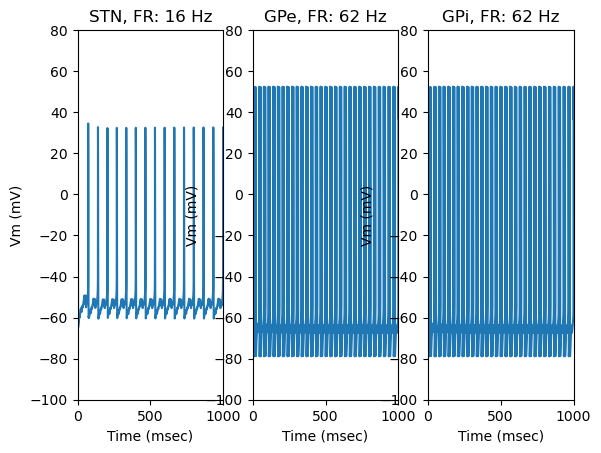

--- 22.907593727111816 seconds ---


In [24]:
def Initial():
    
    start_time = time.time()
    #%% Set initial conditions
    
    #time variables
    tmax=1000              #maximum time (ms)
    dt=0.01                #timestep (ms)
    t=np.arange(0,tmax,dt) #time vector
    n=12                   #number of neurons in each nucleus (TH, STN, GPe, GPi)
    
    #initial membrane voltages for all cells - random is a little different from matlab
    v2=-62+np.random.randn(1,n)*5
    v3=-62+np.random.randn(1,n)*5
    v4=-62+np.random.randn(1,n)*5
    
    #%% Running FOGnetwork
    
    #healthy
    vsn, vge, vgi = network(tmax, dt, v2, v3, v4, n) #healthy
    h = plotres(vsn, vge, vgi, t, tmax, dt)
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    return (vsn, vge, vgi, t, tmax)

if __name__ == "__main__":
    # execute only if run as a script
    fin_res=Initial()